In [32]:
# !pip install torch --user

In [33]:
import io
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

## Carregamento dos dados

In [34]:
dct = {}
dct['codigo'] = 'soja'

In [35]:
df = pd.read_pickle(f'../dados/cepea-{dct["codigo"]}.p')

In [36]:
# Converte index para data
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

# Slice para somente o período desejado
df = df['01/01/2007':'01/01/2021']

In [37]:
df.drop(columns=['preco_real'], axis=1, inplace=True)

In [38]:
# Como uma possível sazonalidade nos preços deve ter ciclo anual, com variação mensal, 
# faremos o resample da série para a média de cada mês
df_mes = df.resample('MS').mean()
df.isnull().any()

preco_dolar    False
dtype: bool

<AxesSubplot:xlabel='data'>

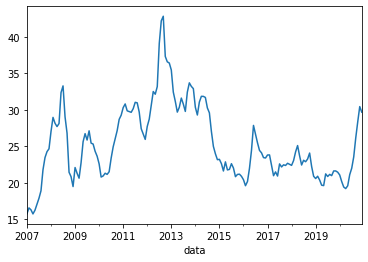

In [39]:
df_mes.preco_dolar.plot()

In [40]:
# Gera train e test sets

# Primeiro, faremos os modelos na periodicidade mensal (para a projeção pontual ao final do período de treino)
sep = df_mes.index.year >= 2019
train = df_mes.preco_dolar[~sep]
test = df_mes.preco_dolar[sep]

# Depois, o modelo diário
sep_oa = df.index.year >= 2020
sep_om = df.index.month > 6
train_o = df.preco_dolar[~(sep_oa & sep_om)]
test_o = df.preco_dolar[sep_oa & sep_om]

In [41]:
# Normalização dos dados. Optamos por ampliar o limite inferior do range para -1 (em vez de 0)
scaler = StandardScaler()

# Fit somente no treino para evitar leakage
fit_scaler = scaler.fit(train.values.reshape(-1,1))

# Transform também no test
n_train = fit_scaler.transform(train.values.reshape(-1,1))
n_test = fit_scaler.transform(test.values.reshape(-1,1))

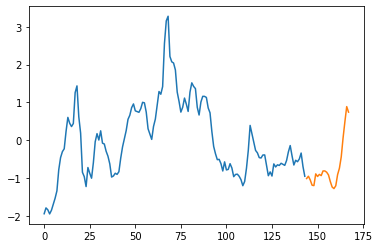

In [42]:
# Mesmo comportamento dos dados do gráfico, mas agora com escala entre -1 e 1
plt.plot(range(len(n_train)),n_train)
plt.plot(range(len(n_train),len(n_train)+len(n_test)),n_test)

In [43]:
n_test.size

24

In [44]:
# Unindo novamente o train e o teste, para criar a window de entrada da LSTM
# Caso contrário, a função criaria um gap entre as duas variaveis igual ao tamanho do número simultaneo de
# observações usadas como features
full_set = np.r_[n_train,n_test]
full_set.size

168

# <center>Desenvolvimento de Modelos Preditivos</center>

---

## MODELO LSTM

Conversão para tensores

In [45]:
# Conversão dos dados em tensores
tensor = torch.FloatTensor(full_set).view(-1) # View -1 é similar ao reshape

In [46]:
# Transforma a entrada em uma sequência de N inputs para cada observação da saída
    
train_window = 24

def create_seq(input_data, tw):
    L = len(input_data)
    x = []
    y = []
    for i in range(L-tw):
        x.append(input_data[i:i+tw])
        y.append(input_data[i+tw:i+tw+1])

    return x, y

x_list, y_list = create_seq(tensor, train_window)

In [47]:
def list_to_tensor(lista_de_tensores):
    t = torch.zeros(len(lista_de_tensores),lista_de_tensores[0].size()[0])
    for e, tensor in enumerate(lista_de_tensores):
        t[e] = tensor
    return t
xtr = list_to_tensor(x_list[:-n_test.size])
ytr = list_to_tensor(y_list[:-n_test.size])
xtt = list_to_tensor(x_list[-n_test.size:])
ytt = list_to_tensor(y_list[-n_test.size:])

---

## Criação da REDE NEURAL RNN - LSTM com Pytorch  
</br>

[Arquitetura LSTM Keras](assets/keras-lstm.png)

In [48]:
print(xtr.size())
print(ytr.size())
print(xtt.size())
print(ytt.size())

torch.Size([120, 24])
torch.Size([120, 1])
torch.Size([24, 24])
torch.Size([24, 1])


In [49]:
X_train = xtr.unsqueeze(2)
y_train = ytr
X_test = xtt.unsqueeze(2)
y_test = ytt

In [50]:
print(X_train.size())
print(y_train.size())
print(X_test.size())
print(y_test.size())

torch.Size([120, 24, 1])
torch.Size([120, 1])
torch.Size([24, 24, 1])
torch.Size([24, 1])


In [51]:
#####################
# Modelo
#####################

class LSTM(nn.Module):

    def __init__(self, n_features, hidden_dim, seq_len, batch, num_layers=2):
        super(LSTM, self).__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.batch = batch
        self.num_layers = num_layers

        # Define Camada LSTM
        self.lstm = nn.LSTM(
            input_size=self.n_features, 
            hidden_size=self.hidden_dim, 
            num_layers=self.num_layers, 
            dropout =.1, # (só pode ser utilizado dropout se número de camadas LSTM for superior a 1 )
        )

        # Define camada linear
        self.linear = nn.Linear(
            in_features=self.hidden_dim, 
            out_features=1
        )
        
        
    def reset_hidden_layer(self):
        self.hidden = (
            torch.zeros(self.num_layers, self.batch, self.hidden_dim),
            torch.zeros(self.num_layers, self.batch, self.hidden_dim)
        )

    def forward(self, input):
        
        lstm_out, self.hidden = self.lstm(
            input
        )

        y_pred = self.linear(
            lstm_out[:,-1,:]
        )
        
        return y_pred


In [52]:
#####################
# Treinamento
#####################

def train_model(model, epochs, train_data, train_labels, test_data, test_labels):
    
    num_epochs = epochs
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    loss_fn = torch.nn.L1Loss() # função de erro MAE
    learning_rate = 1e-3
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for t in range(num_epochs):
        
        model.reset_hidden_layer()
        
        y_pred = model(X_train) # Realizad o Forward
        
        loss = loss_fn(y_pred.float(), y_train)
    
        with torch.no_grad(): # Previne atualização de parâmetros
            y_test_pred = model(X_test)
            test_loss = loss_fn(y_test_pred.float(), y_test)
        test_hist[t] = test_loss.item()

        if t % 10 == 0:  
            print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

        train_hist[t] = loss.item()
              
        loss.backward()

        optimiser.step()
    
        optimiser.zero_grad()

    return  model.eval(), train_hist, test_hist, y_pred.float(), y_test_pred.float()

In [53]:
hi = 17 # nós no hidden layer
epochs = 200
num_layers = 2 # layers LSTM
batch = X_train.size()[0]
# train_window é 24, definida anteriormente

model = LSTM(1, hi, seq_len=train_window, batch=batch, num_layers=num_layers)

In [54]:
model, train_hist, test_hist, pred_train, pred_test = train_model(model, epochs, X_train, y_train, X_test, y_test)

Epoch 0 train loss: 0.7775240540504456 test loss: 0.8771352767944336
Epoch 10 train loss: 0.7581261992454529 test loss: 0.8304681777954102
Epoch 20 train loss: 0.7341004610061646 test loss: 0.7890102863311768
Epoch 30 train loss: 0.6911988854408264 test loss: 0.7520318031311035
Epoch 40 train loss: 0.595512330532074 test loss: 0.7017359733581543
Epoch 50 train loss: 0.4965677261352539 test loss: 0.6127769351005554
Epoch 60 train loss: 0.4737597107887268 test loss: 0.5426856875419617
Epoch 70 train loss: 0.450067937374115 test loss: 0.550372302532196
Epoch 80 train loss: 0.42313334345817566 test loss: 0.5324763655662537
Epoch 90 train loss: 0.40350422263145447 test loss: 0.4757889211177826
Epoch 100 train loss: 0.3772830069065094 test loss: 0.46554383635520935
Epoch 110 train loss: 0.36030495166778564 test loss: 0.463899701833725
Epoch 120 train loss: 0.32771652936935425 test loss: 0.3956691324710846
Epoch 130 train loss: 0.3202011287212372 test loss: 0.39905595779418945
Epoch 140 train

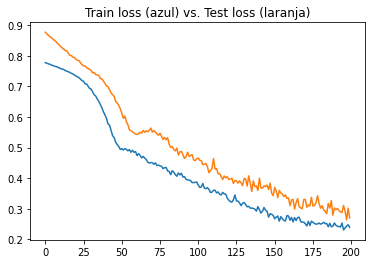

In [55]:
plt.title("Train loss (azul) vs. Test loss (laranja)")
plt.plot(train_hist)
plt.plot(test_hist)

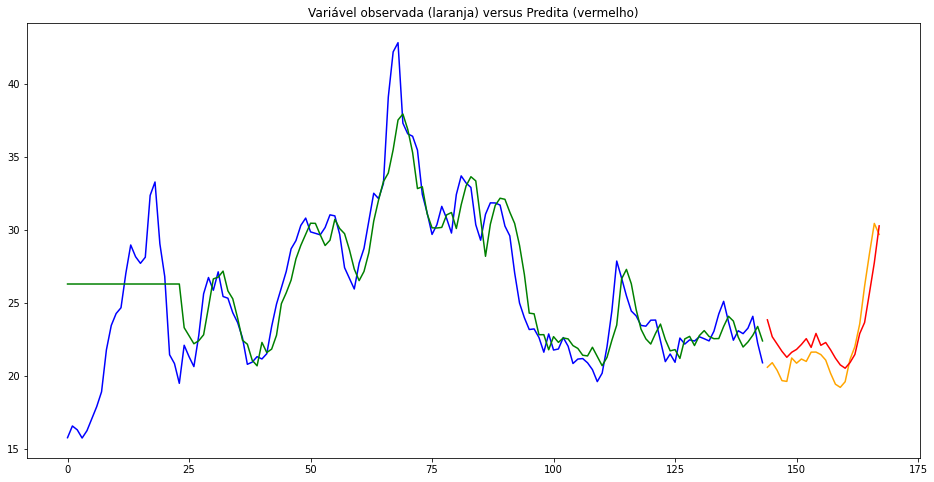

In [59]:
tr = [x.detach().numpy()[0] for x in pred_train]
ts = [x.detach().numpy()[0] for x in pred_test]

tr_normalized = fit_scaler.inverse_transform(tr)
tt_normalized = fit_scaler.inverse_transform(ts)

doze = [np.mean(tr_normalized)] * train_window
tr_doze = np.r_[doze,tr_normalized] # Adiciona itens ao começo da array, para ressincronizar aos dados originais

# Compara

plt.figure(figsize=(16,8))
plt.title('Variável observada (laranja) versus Predita (vermelho)')
plt.plot(range(len(train.values)),train.values, color='blue')
plt.plot(range(len(train.values),len(train.values)+len(test.values)),test.values, color='orange')
plt.plot(range(len(tr_doze)),tr_doze, color='green')
plt.plot(range(len(tr_doze),len(tr_doze)+len(tt_normalized)),tt_normalized, color='red')

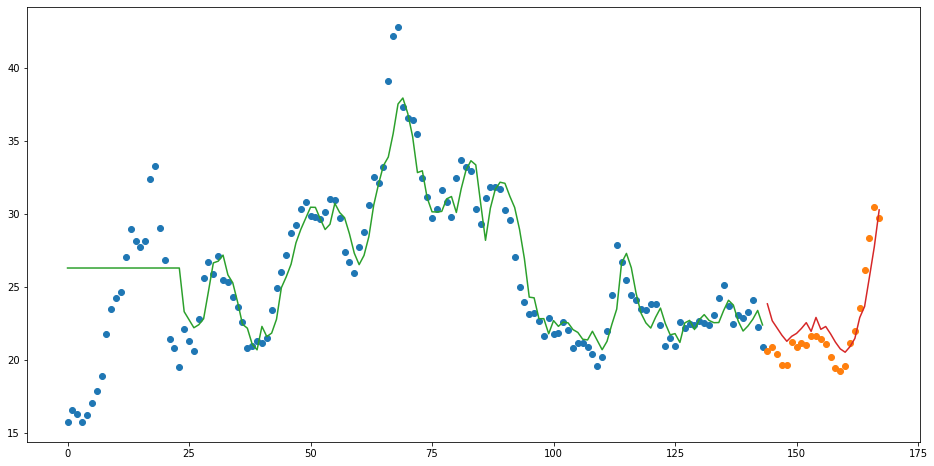

In [57]:
plt.figure(figsize=(16,8))
plt.plot(range(len(train.values)),train.values, 'o')
plt.plot(range(len(train.values),len(train.values)+len(test.values)),test.values, 'o')
plt.plot(range(len(tr_doze)),tr_doze)
plt.plot(range(len(tr_doze),len(tr_doze)+len(tt_normalized)),tt_normalized)